---
# Logistic Regression with Feature Engineering and Augmented Data
---
### Summary:

To evaluate the performance of the Logistic Regression model with feature extraction when trained on augmented data. 
By augmenting MNIST sign language dataset, more noise is added to the images which simulate real-world scenario. 
Training the model on augmented data allows the model to generalise better and therefore become more robust.

### Notebook Overview:

- **Data Augmentation**:
    - Load augmented data and put into an array format for model compatibility.

- **Feature Extraction**:
    - Using HOG, LBP and Colour histogramming to create feature vectors out of images
    - To perform feature extraction with augmented data

- **Build Logistic Regression Model**:
    - Train a Logistic Regression model on the augmented data.
    - Compare the performance of the model with and without augmentation.

- **Model Evaluation**:
    - Evaluate the accuracy and performance of the Logistic Regression model.
    - Assess model coefficients to see what model has learnt when data includes augmentation

### Data Augmentation Reminder:

- rescale=1./255             > Normalisation of the input data is best when working with neural networks
- rotation_range=20          > To enusre model is able to deal with slight tilts in the hand position, most likley to occur in the real world
- width_shift_range=0.1      > To ensure model is able to deal with off-centered images
- height_shift_range=0.1     > To ensure model is able to deal with off-centered images
- shear_range=0.2            > To distort the image, similar to when we see objects from different perspectives
- zoom_range=0.2             > Zooms in and out of images so model is able to recognise signs when hands are of different sizes/furhter/closer.
- horizontal_flip=False      > Not applying horizontal flip as this would add confusion since sign language signs require specific orientations.



## Set Up

In [1]:
# List of imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler

import joblib

## Data Loading

In [2]:
# connect to google drive -> required for input image later
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
X_aug = joblib.load( '../../model/my_files/X_train_aug.pkl')
y_aug = joblib.load( '../../model/my_files/y_train_aug.pkl')


In [4]:
all_images = []

# Iterate over each array in X_aug
for batch in X_aug:
    # Iterate over each image in the batch
    for image in batch:
        # Append the image to the list of all images
        all_images.append(image)

# Convert the list of images to a NumPy array
all_images_array = np.array(all_images)

In [5]:
all_class = []

# Iterate over each array in X_aug
for batch in y_aug:
    # Iterate over each image in the batch
    for c in batch:
        # Append the image to the list of all images
        all_class.append(c)

# Convert the list of images to a NumPy array
all_class_array = np.array(all_class)

In [6]:
# Set new X and y to be augmented images
X = all_images_array

In [7]:
# Convert the list of images to a NumPy array
y = all_class_array

In [8]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y, return_counts=True)

## Utility Functions

In [9]:
def extract_features(image):
  '''
    Overview:
    Extracts HOG, LBP, and color histogram features from a 28x28 image.

    Arguments:
        - single image

    Output:
        - feature vector for a given image
  '''
  # Reshape the image if it's flattened
  image = image.reshape(28, 28)

  # Histogram of Orientated Gradients (HOG) Features
  hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

  # LBP Features (Uniform LBP with 8 neighbors)
  lbp_features = local_binary_pattern(image, P=8, R=1, method='uniform')
  lbp_hist, bin_edges = np.histogram(lbp_features, bins=np.arange(0, lbp_features.max() + 2), density=True)

  # Color Histogram Features (8 bins per channel) -> distribution of colour (greyscale in this case)
  color_hist, bin_edges = np.histogram(image, bins=8, range=(0, 255), density=True)

  # Combining features into a single vector
  feature_vectors = np.concatenate((hog_features, lbp_hist, color_hist)) # default axis =0

  return feature_vectors


# Function to plot output of the feature engineering methods
def feature_plots(input_letter):
    '''
      Overview:
        Plot to compare the original input image with the output of a given feature engineering method.

      Arguments:
        - input_letter: letter (NOT J/Z as both of these letters do not exist in dataset).
        - feature_image: The output image after feature engineering.

      Output:
        - 2 figures:
            - input image of given letter
            - image of 'new' feature
    '''

    my_image = X.reshape(-1,28,28)
    my_class = y

    if input_letter.lower() in ('j', 'z'):
            raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:
        fig, axes = plt.subplots(1,3, figsize=(10, 5))

        idx1 = alphabet.index(input_letter.lower())

        feature_vector, hog_image  = hog(my_image[my_class==idx1][0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        lbp_features = local_binary_pattern(my_image[my_class==idx1][0], P=8, R=1, method='uniform')

        axes[0].imshow(lbp_features, cmap="gray")
        axes[0].set_title(f'Image of {input_letter.upper()} after LBP')
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].imshow(my_image[my_class==idx1][0], cmap="gray")
        axes[1].set_title(f'Input Image of {input_letter.upper()}')
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        axes[2].imshow(hog_image, cmap="gray")
        axes[2].set_title(f'Image of {input_letter.upper()} after HOG')
        axes[2].set_xticks([])
        axes[2].set_yticks([])

        plt.tight_layout()
        plt.show()

def assess_coef(coef, letter_1, letter_2):
    '''
    Overview:
    Plots vector coefficients for letter_1 and letter_2 .

    Arguments:
        - coef -> Model coefficients for all letters/classes
        - letter_1 -> Letter (NOT J/Z as both of these letters do not exist in dataset)
        - letter_2 -> Letter (NOT J/Z as both of these letters do not exist in dataset)

    Output:
        - 2 figures:
            - vector coefficient for letter_1
            - vector coefficient for letter_2

    '''
    if (letter_1.lower() in ('j', 'z')) or (letter_2.lower() in ('j', 'z')):
            raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:
        fig, axes = plt.subplots(2,1, figsize=(15, 5))

        # get index of letter as class is int data type
        idx_1= alphabet.index(letter_1.lower()) # having to use second alphabet list here without j and z as indicies for coef do not align with target
        idx_2= alphabet.index(letter_2.lower())

        axes[0].imshow(np.tile(coef[idx_1], (10, 1)),cmap = 'gray')
        axes[0].set_title(letter_1.upper(),fontsize='20')
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].imshow(np.tile(coef[idx_2], (10, 1)),cmap = 'gray')
        axes[1].set_title(letter_2.upper(),fontsize='20')
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        plt.tight_layout()
        plt.show()



## Building the Logistic Regression Model


### Transform images to feature vectors


In [10]:
# creating feature vectors for all images in dataset
image_feature_vectors = []
for image in X:
    image_feature_vectors.append(extract_features(image))
image_feature_vectors = np.array(image_feature_vectors)


/Users/simybasra/anaconda3/lib/python3.11/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [11]:
# Sanity check on shape
image_feature_vectors.shape


(27701, 162)

### Test/Train Data Split

In [12]:
X_vec = image_feature_vectors


In [13]:
X_vec.shape

(27701, 162)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_vec, y, test_size = 0.2, random_state=1)

In [15]:
X_train.shape

(22160, 162)

In [16]:
y_train.shape

(22160,)

In [17]:
my_model = LogisticRegression(solver='saga', penalty='l1', C=1, max_iter=1000)

In [18]:
my_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

### Model Results

In [19]:
print(f'train score: {my_model.score(X_train, y_train).round(4)}')
print(f'val_score:{my_model.score(X_val,y_val).round(4)}')


train score: 0.6116
val_score:0.5824


**Comment**
Performance is very bad as expected, in the following sprint I need to reduce the amount of augmentation performed on my images.

In [21]:
# saving model as pkl file
joblib.dump(my_model, '../../model/my_files/log_reg_fe_AUG.pkl')

['../../model/my_files/log_reg_fe_AUG.pkl']

In [22]:
my_log_reg = joblib.load('../../model/my_files/log_reg_fe_AUG.pkl')

## Model Evaluation

### Confusion Matrix

In [23]:
pred_y = my_log_reg.predict(X_val)

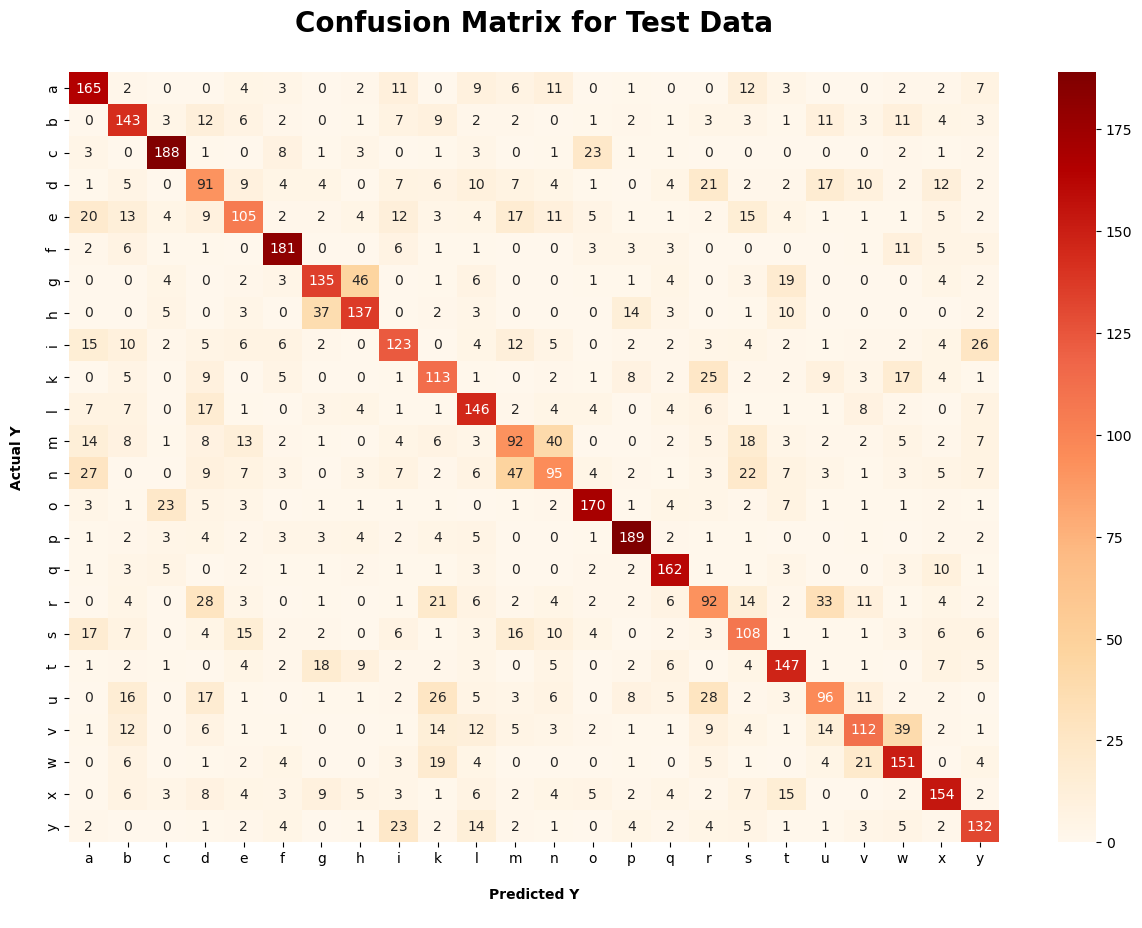

In [24]:
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Assessing model coefficients

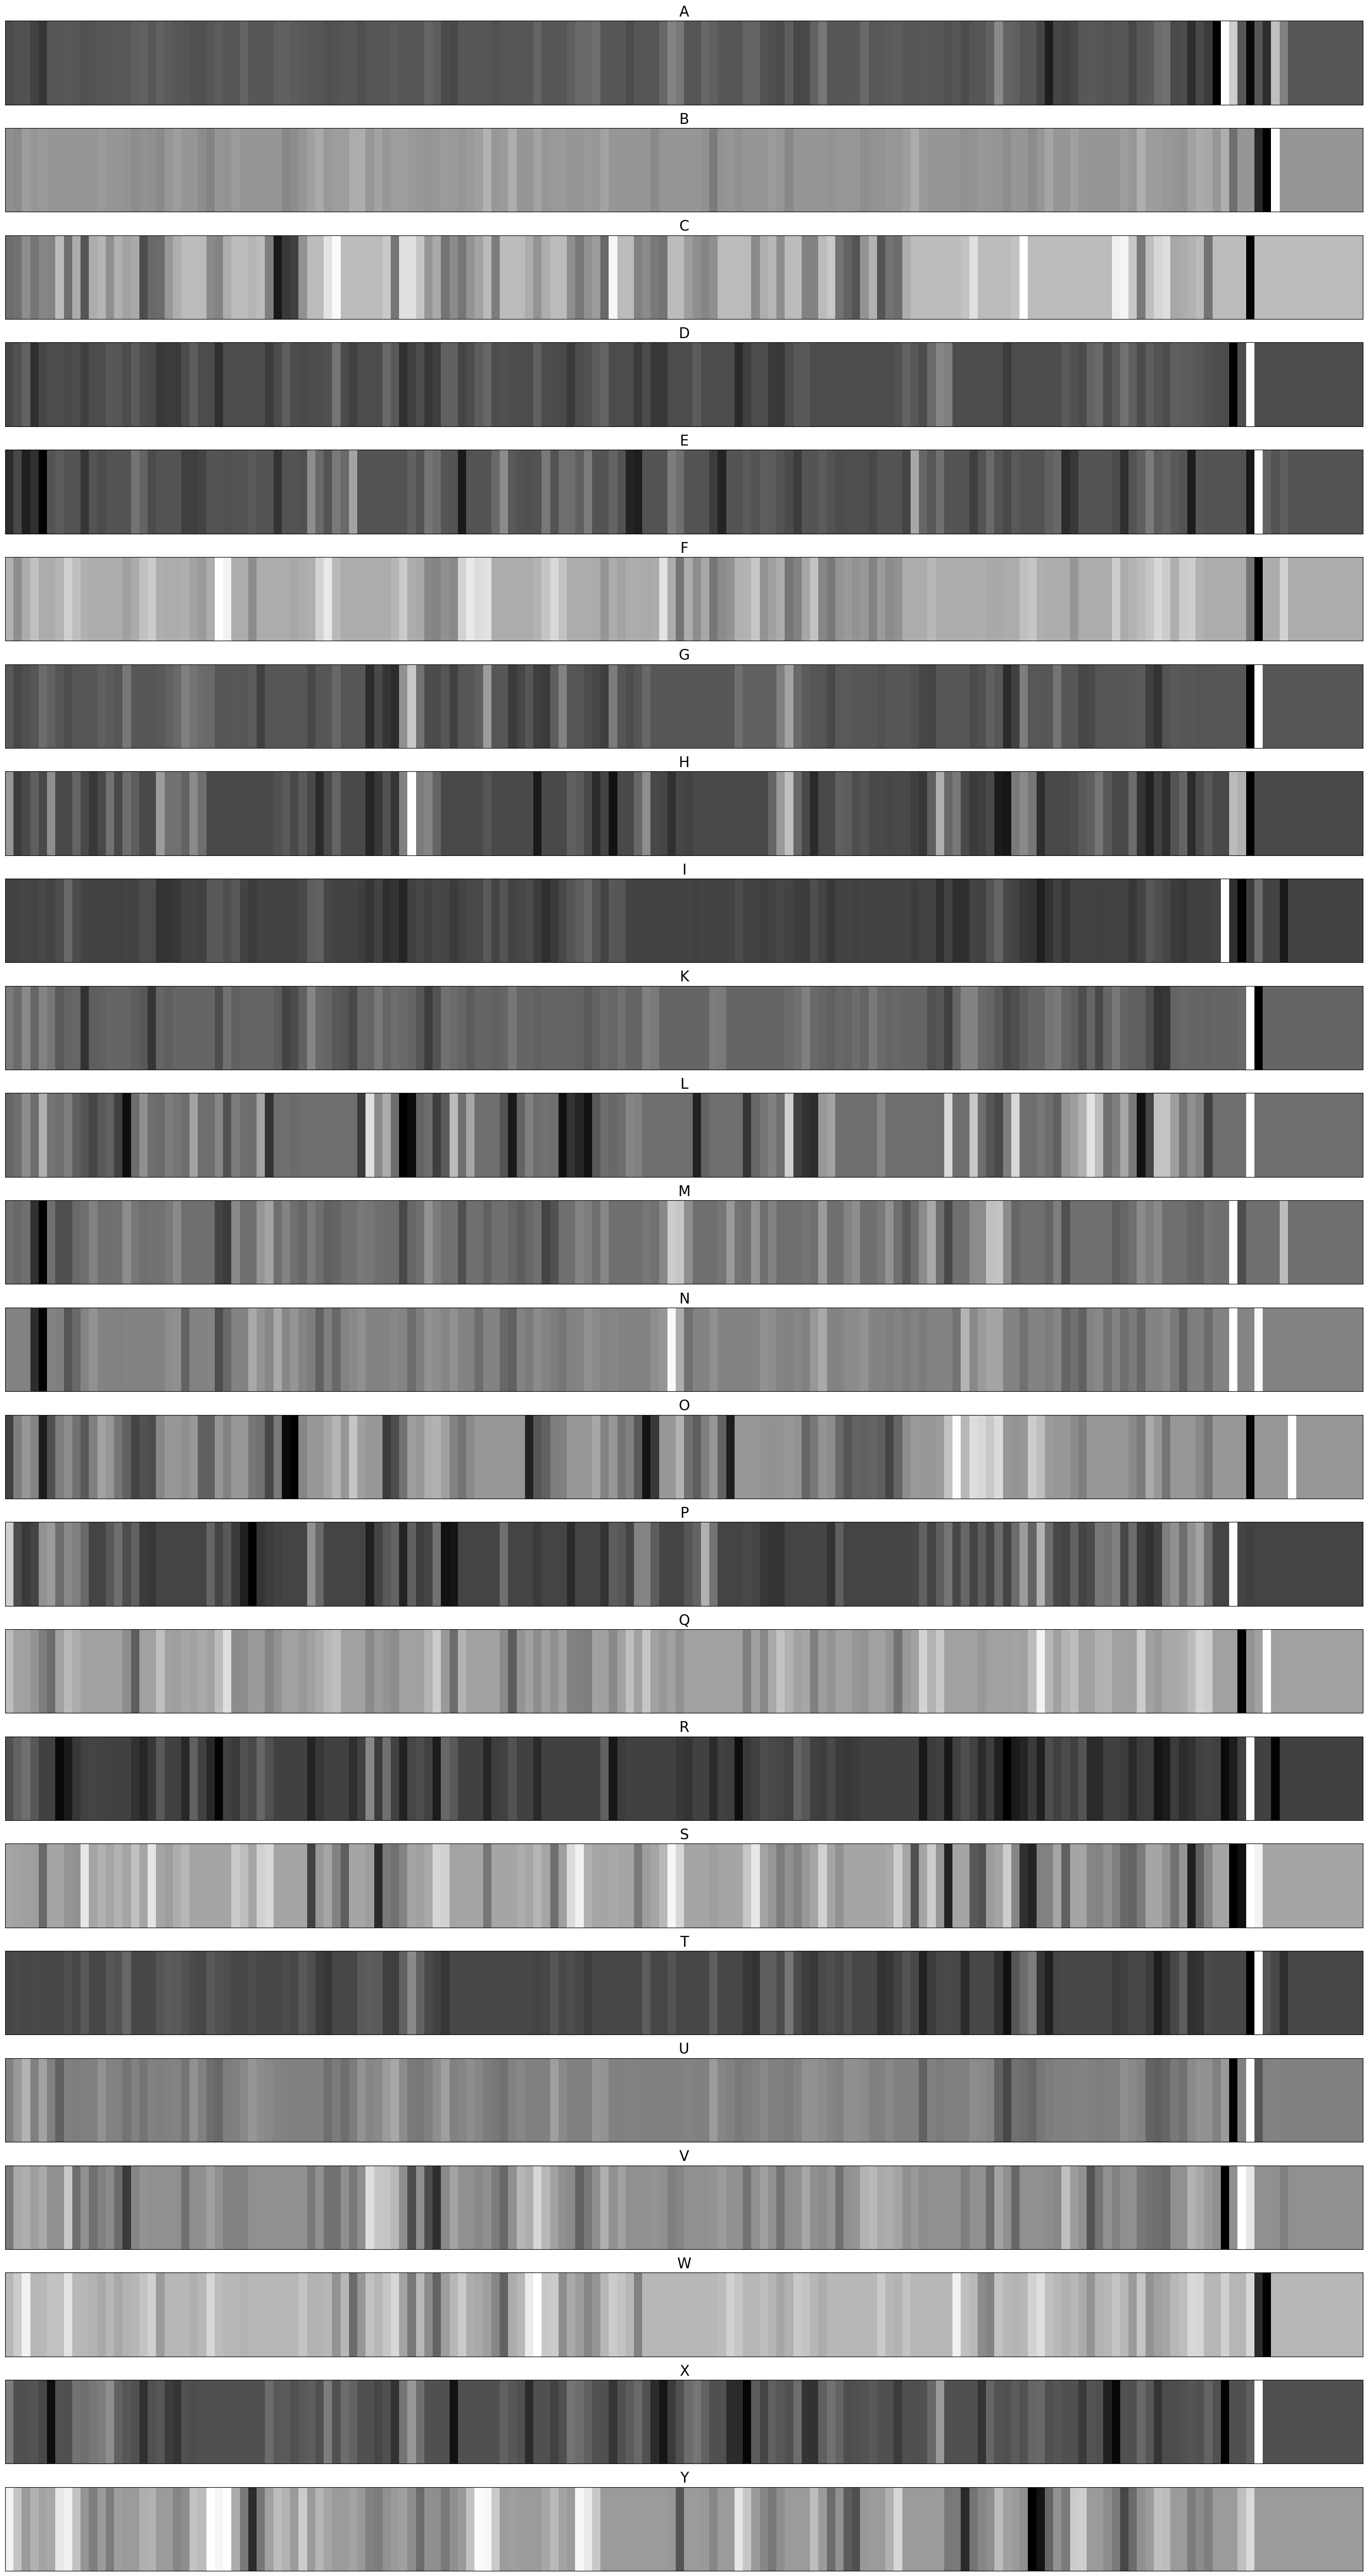

In [25]:
# Plotting of vector coefficients
letter_coef = my_log_reg.coef_

fig, axes = plt.subplots(24,1, figsize=(50, 50))

for i,coef in enumerate(letter_coef):
    axes[i].imshow(np.tile(coef, (10, 1)), cmap='gray')
    axes[i].set_title(alphabet[i].upper(),fontsize='20') #-> using alphabet_jz as the i is 0 to 24
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

**Comment:**
Now we see there is a lot of simialriteis between our vectors, this makes sense as wehn we look at the mean images the texture, edges and corners of the hands are all fairly similar and so when we perform feature extraction resulting vectors are very simialr to each other between letters.

Using the function assess_coef we will explore the similarity between the vectors further.


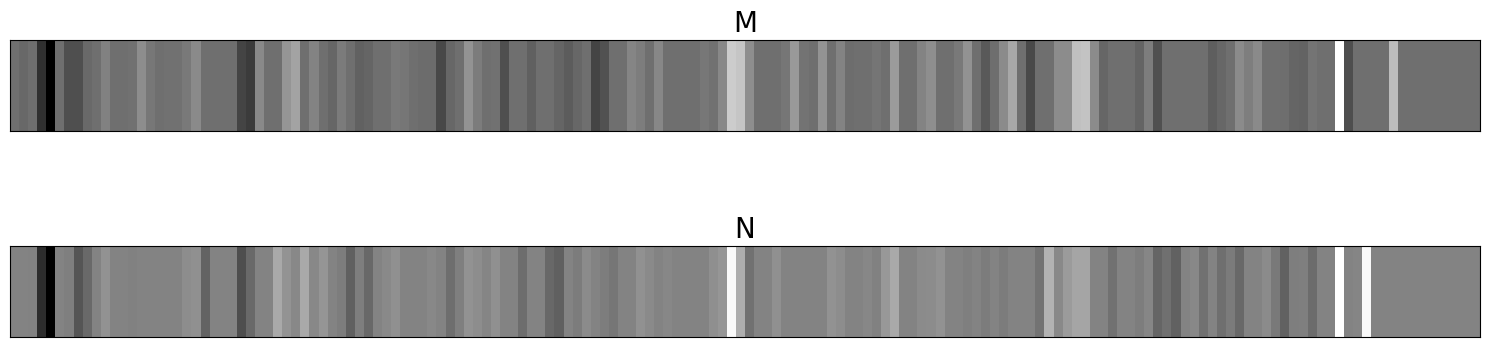

In [28]:
# Using confusion matrix identify two letters where misclassification occurs
# Assess vectors side by side to see if the coefficient vectors are similar
assess_coef(my_log_reg.coef_, 'm', 'n')


**Comment:**
See there is a lot of similarity between feature vectors for D and E, to further investgate how simialar each of these vectors are we can look at an example of D and E after HOG and LBP is applied to uncover which areas of the iamge are a across over between the two.

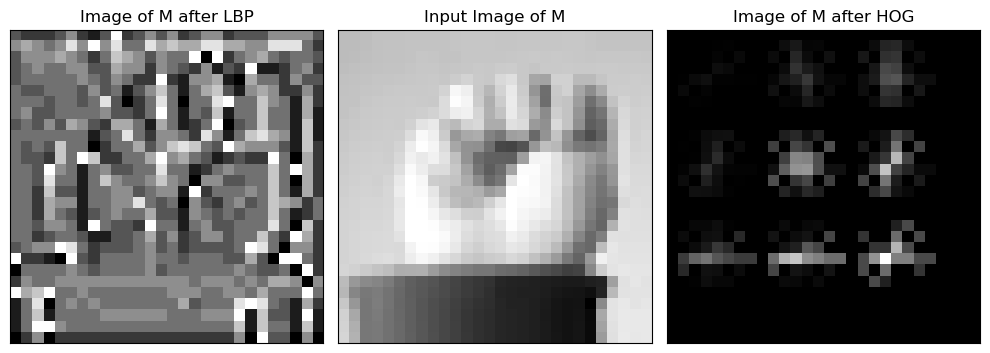

In [29]:
feature_plots('m')

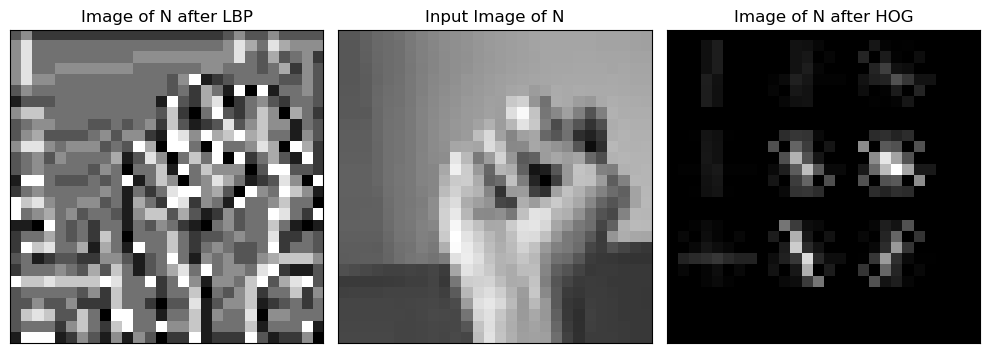

In [30]:
feature_plots('n')

**Comment:**
There are alot of simialrities especially when we look at the HOG image for both D and E. Since HOG makes up majority of the final feature vector, the similairity we are seeing in the first section (0 to 144) of the coefficients for D and E are from HOG.

## Test Image

In [ ]:
# Load model
my_log_reg = joblib.load('/content/drive/My Drive/Colab Notebooks/Capstone/my_files/log_reg_fe_AUG.pkl')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

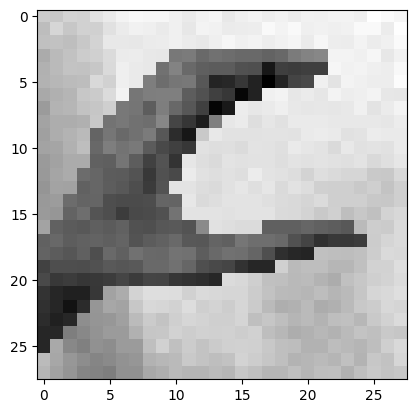

In [ ]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [ ]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image)

In [ ]:

# Reshaping to have dimesntions (1,28,28,1) -> to match X_train/X_test dimensions
# 1 as only single image is uploaded
test_img = image_array.reshape(28,28)

In [ ]:
feature_vec = extract_features(test_img)

In [ ]:
feature_vec.shape

(162,)

In [ ]:
feature_vec =feature_vec.reshape(1,-1)

In [ ]:
feature_vec.shape

(1, 162)

In [ ]:
pred = my_model.predict(feature_vec)

In [ ]:
pred

array([2])

In [ ]:
alphabet[pred[0]]

'c'

Surprinsingly makes the correct prediction for a 'real' image of C. Looking at the confusion matrix letter C has one of the highest correct predictions but still this is relatively low and would want need to reduce augmentation to increase performance.

In [ ]:
# TODO:
# Expand on explanations
# Fix augmentation - decide on best augmention to perform
